In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
from tqdm.notebook import tqdm
import multiprocessing 
from collections import defaultdict
from itertools import product

# tf.config.set_visible_devices([], 'GPU')

from rdkit import Chem
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw
from rdkit import DataStructs

import sys
sys.path.append('../src/')

from ops import transform_ops
from gcn.datasets import GCNDataset
from gcn.models import GCNModel
from gcn import saliency

In [2]:
hilic_dataset = GCNDataset(
    [f'../input/tfrecords/Fiehn_HILIC/train.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/valid.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_1.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_2.tfrec'], 
    1, False).get_iterator()

rplc_dataset = GCNDataset(
    [f'../input/tfrecords/RIKEN/train.tfrec',
     f'../input/tfrecords/RIKEN/valid.tfrec',
     f'../input/tfrecords/RIKEN/test_1.tfrec',
     f'../input/tfrecords/RIKEN/test_2.tfrec'], 
    1, False
).get_iterator()


In [3]:
def compute_similarity_score(a, b):
    mols = [Chem.MolFromSmiles(a), Chem.MolFromSmiles(b)]
    fps = [Chem.RDKFingerprint(mol) for mol in mols]
    score = DataStructs.FingerprintSimilarity(fps[0], fps[1])
    return score


hilic_data = []
rplc_data = []

for example_1 in tqdm(hilic_dataset):
    for example_2 in rplc_dataset:

        a = example_1['string'].numpy()[0][0].decode('utf-8')
        b = example_2['string'].numpy()[0][0].decode('utf-8')
        #a = Chem.CanonSmiles(a)
        #b = Chem.CanonSmiles(b)
        a = Chem.MolFromSmiles(a)
        b = Chem.MolFromSmiles(b)
        
        if (a.HasSubstructMatch(b) and b.HasSubstructMatch(a)):
            
            A = example_1['adjacency_matrix'].numpy()[0]
            H = example_1['feature_matrix'].numpy()[0]
            y = example_1['label'].numpy()[0]
            s = example_1['string'].numpy()[0][0].decode('utf-8')
            i = example_1['index'].numpy()[0][0]
            
            hilic_data.append((A, H, y, a, i))
            
            A = example_2['adjacency_matrix'].numpy()[0]
            H = example_2['feature_matrix'].numpy()[0]
            y = example_2['label'].numpy()[0]
            s = example_2['string'].numpy()[0][0].decode('utf-8')
            j = example_2['index'].numpy()[0][0]
            
            rplc_data.append((A, H, y, b, j))
            
        

In [12]:
data1 = pd.read_csv('../input/datasets/Fiehn_HILIC.csv')
data2 = pd.read_csv('../input/datasets/RIKEN.csv')

In [ ]:
# 18
# 20
# 33
# 35
# 36
# 37
# 58
# 60
# 69
# 39
# 1
# 68

In [11]:
# for i, (d, z) in enumerate(zip(rplc_data, hilic_data)):
#     print(i, d[-1], z[-1])

0 851 881
1 295 141
2 224 903
3 218 330
4 747 416
5 386 416
6 78 512
7 779 936
8 184 563
9 218 945
10 784 948
11 228 951
12 465 961
13 84 811
14 309 963
15 778 964
16 390 118
17 221 997
18 308 999
19 227 139
20 243 1020
21 244 1021
22 127 174
23 302 201
24 320 234
25 139 238
26 473 241
27 240 250
28 388 283
29 141 294
30 278 303
31 662 315
32 237 315
33 290 322
34 451 336
35 247 358
36 62 359
37 247 386
38 255 387
39 263 392
40 492 393
41 695 393
42 696 393
43 214 397
44 393 479
45 231 519
46 134 592
47 233 593
48 197 596
49 198 599
50 19 611
51 311 617
52 842 617
53 403 629
54 250 645
55 297 652
56 321 657
57 307 716
58 306 717
59 225 725
60 230 761
61 84 798
62 215 799
63 278 814
64 315 815
65 491 817
66 300 842
67 424 846
68 308 850
69 316 856
70 54 869
71 253 870
72 746 872
73 22 876


In [26]:
# print(data2.iloc[316].compound_name, data.iloc[856].compound_name)

Quercetin-3-O-glucosyl-6''-acetate Quercetin-3-O-beta-glucopyranosyl-6'-acetate


In [4]:
# pair = 0
# for example_1 in tqdm(hilic_dataset):
#     for example_2 in rplc_dataset:

#         a = example_1['string'].numpy()[0][0].decode('utf-8')
#         b = example_2['string'].numpy()[0][0].decode('utf-8')

#         score = compute_similarity_score(a, b)
#         if score >= 1.0:

#             A = example_1['adjacency_matrix'].numpy()[0]
#             H = example_1['feature_matrix'].numpy()[0]
#             y = example_1['label'].numpy()[0]
#             s = example_1['string'].numpy()[0][0].decode('utf-8')
#             i = example_1['index'].numpy()[0][0]
            
#             saliency_map = saliency_hilic.atom_importance(A, H, y)
#             mol = transform_ops.mol_from_string(s)
#             saliency_hilic.draw_atom_saliency_on_mol(
#                 mol, saliency_map, f'../output/saliency/mol_pair_{pair}_Fiehn_HILIC_{i}.png')
            
            
#             A = example_2['adjacency_matrix'].numpy()[0]
#             H = example_2['feature_matrix'].numpy()[0]
#             y = example_2['label'].numpy()[0]
#             s = example_2['string'].numpy()[0][0].decode('utf-8')
#             i = example_2['index'].numpy()[0][0]
            
#             saliency_map = saliency_rplc.atom_importance(A, H, y)
#             mol = transform_ops.mol_from_string(s)
#             saliency_rplc.draw_atom_saliency_on_mol(
#                 mol, saliency_map, f'../output/saliency/mol_pair_{pair}_RIKEN_{i}.png')
            
            
#             pair += 1
            

In [17]:
def vanilla_atom_saliency(model, A, H, y):

    # remove potential padding
    keep_idx = np.where(A.sum(axis=1) != 0)[0]
    H = tf.convert_to_tensor(H[keep_idx])[tf.newaxis]
    A = tf.convert_to_tensor(A[keep_idx][:, keep_idx])[tf.newaxis]
    y = tf.convert_to_tensor(y)[tf.newaxis]

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(H)
        y_pred = model([A, H], training=False)
        loss = tf.compat.v1.losses.huber_loss(y, y_pred)
    
    gradients = tape.gradient(loss, H)
    gradients = tf.abs(gradients)
    return tf.reduce_sum(gradients[0], axis=1).numpy()


def vanilla_bond_saliency(gcn_model, A, H, y):
    
    
    idx_nonzero = tf.where(A > 0)
    A_nonzero = tf.gather_nd(A, idx_nonzero)

    y = tf.convert_to_tensor(y)[tf.newaxis]

    with tf.GradientTape() as tape:
        tape.watch(A_nonzero)
        A = tf.scatter_nd(idx_nonzero, A_nonzero, shape=A.shape)
        y_pred = gcn_model([A[tf.newaxis], H[tf.newaxis]], training=False)
        loss = tf.compat.v1.losses.huber_loss(y, y_pred)

    gradients = tape.gradient(loss, A_nonzero)
    gradients = tf.abs(gradients)
    return gradients.numpy()#tf.math.segment_sum(gradients, idx_nonzero[:, 0])


def integrated_atom_saliency(gcn_model, A, H, y, m_steps=20):
    """
    Based on: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    And: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/interpretability/saliency_maps/integrated_gradients.py
    """
    alphas = np.linspace(0.1, 1.0, m_steps)
    
    H_baseline = tf.zeros(H.shape, dtype=H.dtype)
    
    gradients_batch = tf.TensorArray(tf.float32, size=m_steps)
    
    y = tf.convert_to_tensor(y)[tf.newaxis]
    
    for i in tf.range(0, len(alphas), 1):
        H_step = H_baseline + alphas[i] * (H - H_baseline)
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(H_step)
            pred = gcn_model([A[tf.newaxis], H_step[tf.newaxis]], training=False)
            loss = tf.compat.v1.losses.huber_loss(y, pred)
        
        gradients = tape.gradient(loss, H_step)
        
        gradients_batch = gradients_batch.write(i, gradients)
    
    gradients_batch = gradients_batch.stack()
    
    # riemann_trapezoidal: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    integrated_gradients = (gradients_batch[:-1] + gradients_batch[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(integrated_gradients, axis=0)
    
    integrated_gradients = (H - H_baseline) * integrated_gradients
    
    return tf.reduce_sum(tf.abs(integrated_gradients), axis=-1).numpy()


def integrated_atom_saliency2(gcn_model, A, H, y, m_steps=20):
    """
    Based on: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    And: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/interpretability/saliency_maps/integrated_gradients.py
    """
    alphas = np.linspace(0.1, 1.0, m_steps)
    
    H_baseline = tf.zeros(H.shape, dtype=H.dtype)
    
    gradients_batch = tf.TensorArray(tf.float32, size=m_steps)

    for i in tf.range(0, len(alphas), 1):
        H_step = H_baseline + alphas[i] * (H - H_baseline)
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(H_step)
            pred = gcn_model([A[tf.newaxis], H_step[tf.newaxis]], training=False)[0]
            
            y = tf.constant(0.0)
            y += tf.stop_gradient(pred)
            y += 1.0
            loss = tf.compat.v1.losses.huber_loss(y, pred)
        
        gradients = tape.gradient(loss, H_step)
 
        gradients_batch = gradients_batch.write(i, gradients)
    
    gradients_batch = gradients_batch.stack()
    
    # riemann_trapezoidal: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    integrated_gradients = (gradients_batch[:-1] + gradients_batch[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(integrated_gradients, axis=0)
    
    integrated_gradients = (H - H_baseline) * integrated_gradients
    
    return tf.reduce_sum(integrated_gradients, axis=-1).numpy() #* (y[0]-pred[0].numpy())


def smoothgrad_atom_saliency(gcn_model, A, H, y, m_steps=50, noise=0.1):
    """
    Based on: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    And: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/interpretability/saliency_maps/integrated_gradients.py
    """
    
    gradients_batch = tf.TensorArray(tf.float32, size=m_steps)

    for i in tf.range(m_steps):
        H_noisy = H + tf.random.normal(shape=(1, H.shape[1]), mean=0.0, stddev=noise)
        with tf.GradientTape() as tape:
            tape.watch(H_noisy)
            pred = gcn_model([A[tf.newaxis], H_noisy[tf.newaxis]])[0]
            loss = tf.compat.v1.losses.huber_loss(y, pred)
        
        gradients = tape.gradient(loss, H_noisy)
        
        gradients_batch = gradients_batch.write(i, tf.abs(gradients))
    
    gradients_batch = gradients_batch.stack()
    
    avg_gradients = tf.math.reduce_mean(gradients_batch, axis=0)
    
    return tf.reduce_sum(avg_gradients, axis=-1).numpy()


def integrated_bond_saliency(gcn_model, A, H, y, m_steps=20, epsilon=1e-7):
    """
    Based on: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    And: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/interpretability/saliency_maps/integrated_gradients.py
    
    A = [[0, 1, 0, 1],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [1, 0, 1, 0]]  
    S = [5.2, 4.1, 3.7, 0.6, 1.1, 3.2]
    
    --> AS = [[0,   5.2, 0,   4.1],
              [3.7, 0,   0,   0  ],
              [0,   0,   0,   0.6],
              [1.1, 0,   3.2, 0]] 
    """
    alphas = np.linspace(0.0, 1.0, m_steps)
    
    idx_nonzero = tf.where(A > 0)
    A_nonzero = tf.gather_nd(A, idx_nonzero)
    y = tf.convert_to_tensor(y)[tf.newaxis]
    
    A_baseline = tf.zeros(A_nonzero.shape, dtype=A_nonzero.dtype) + epsilon
    
    gradients_batch = tf.TensorArray(tf.float32, size=m_steps)

    for i in tf.range(0, len(alphas), 1):
        A_step = A_baseline + alphas[i] * (A_nonzero - A_baseline)
        with tf.GradientTape() as tape:
            tape.watch(A_step)
            A_step_ = tf.scatter_nd(idx_nonzero, A_step, shape=A.shape)
            pred = gcn_model([A_step_[tf.newaxis], H[tf.newaxis]])
            loss = tf.compat.v1.losses.huber_loss(y, pred)
        
        gradients = tape.gradient(loss, A_step)
        
        gradients_batch = gradients_batch.write(i, gradients)
    
    gradients_batch = gradients_batch.stack()
    
    # riemann_trapezoidal: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    integrated_gradients = (gradients_batch[:-1] + gradients_batch[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(integrated_gradients, axis=0)
    
    integrated_gradients = (A_nonzero - A_baseline) * integrated_gradients
    
    return tf.abs(integrated_gradients).numpy()

def vanilla_bond_saliency(gcn_model, A, H, y):
    '''
    A = [[0, 1, 0, 1],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [1, 0, 1, 0]]  
    S = [5.2, 4.1, 3.7, 0.6, 1.1, 3.2]
    
    --> AS = [[0,   5.2, 0,   4.1],
              [3.7, 0,   0,   0  ],
              [0,   0,   0,   0.6],
              [1.1, 0,   3.2, 0]] 
    
    '''
    
    idx_nonzero = tf.where(A > 0)
    A_nonzero = tf.gather_nd(A, idx_nonzero)
    y = tf.convert_to_tensor(y)[tf.newaxis]

    with tf.GradientTape() as tape:
        tape.watch(A_nonzero)
        A = tf.scatter_nd(idx_nonzero, A_nonzero, shape=A.shape)
        y_pred = gcn_model([A[tf.newaxis], H[tf.newaxis]])
        loss = tf.compat.v1.losses.huber_loss(y, y_pred)

    gradients = tape.gradient(loss, A_nonzero)
    gradients = tf.abs(gradients)
    return gradients.numpy()#tf.math.segment_sum(gradients, idx_nonzero[:, 0])


def draw_atom_saliency_on_mol(mol, saliency, path, size=(1000, 1000)):

    if not os.path.isdir('/'.join(path.split('/')[:-1])):
        os.makedirs('/'.join(path.split('/')[:-1]))

    drawer = Draw.MolDraw2DCairo(*size)
    drawer.drawOptions().bondLineWidth = 3

    saliency = saliency / saliency.max()
    
    Draw.SimilarityMaps.GetSimilarityMapFromWeights(
        mol=mol,
        weights=[float(s) for s in saliency],
        size=size,
        coordScale=1.0,
        colors='g',
        alpha=0.4,
        contourLines=10,
        draw2d=drawer);

    drawer.FinishDrawing()
    drawer.WriteDrawingText(path)
    

for example_1 in tqdm(rplc_dataset.take(7)):
    A = example_1['adjacency_matrix'].numpy()[0]
    H = example_1['feature_matrix'].numpy()[0]
    y = example_1['label'].numpy()[0]
    s = example_1['string'].numpy()[0][0].decode('utf-8')
    i = example_1['index'].numpy()[0][0]

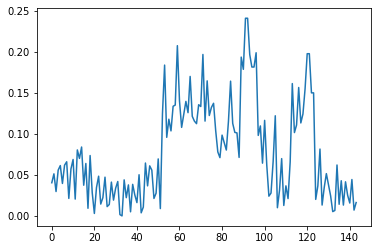

In [93]:
saliency_map = vanilla_bond_saliency(gcn_model_rplc, A, H, y)
plt.plot(range(len(saliency_map)), saliency_map)

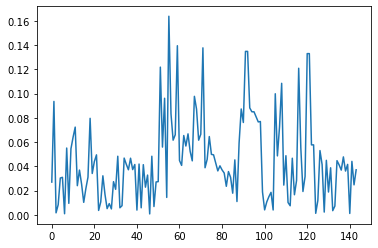

In [190]:
saliency_map = integrated_bond_saliency(gcn_model_rplc, A, H, y)
plt.plot(range(len(saliency_map)), saliency_map)

In [175]:
saliency_map = vanilla_atom_saliency(gcn_model_rplc, A, H, y)
mol = transform_ops.mol_from_string(s)
draw_atom_saliency_on_mol(mol, saliency_map, 'bar/test_1.png')

RuntimeError: Pre-condition Violation
	size mismatch
	Violation occurred on line 295 in file Code/GraphMol/MolDraw2D/MolDraw2DUtils.cpp
	Failed Expression: locs.size() == weights.size()
	RDKIT: 2020.09.1
	BOOST: 1_73


In [132]:
saliency_map = integrated_atom_saliency(gcn_model_rplc, A, H, y)
mol = transform_ops.mol_from_string(s)
draw_atom_saliency_on_mol(mol, saliency_map, f'bar/test_2.png')

In [5]:
batch_size = 32
num_epochs = 100

# Train on all data
train_dataset_hilic = GCNDataset(
    [f'../input/tfrecords/Fiehn_HILIC/train.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/valid.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_1.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_2.tfrec'], 
    batch_size, training=True)

# build model (with default hyper-parameters)
gcn_model_hilic = GCNModel(gconv_units=[128, 128,], gconv_activation='tanh', dense_activation='tanh')

# fit model for {num_epochs} with a batch_size of {batch_size}
gcn_model_hilic.fit(
    train_dataset_hilic.get_iterator(), 
    epochs=num_epochs, verbose=1
)

gcn_model_hilic.compile(optimizer=tf.keras.optimizers.SGD())


# Train on all data
train_dataset_rplc = GCNDataset(
    [f'../input/tfrecords/RIKEN/train.tfrec',
     f'../input/tfrecords/RIKEN/valid.tfrec',
     f'../input/tfrecords/RIKEN/test_1.tfrec',
     f'../input/tfrecords/RIKEN/test_2.tfrec'], 
    batch_size, training=True)

# build model (with default hyper-parameters)
gcn_model_rplc = GCNModel(gconv_units=[128, 128,], gconv_activation='tanh', dense_activation='tanh')

# fit model for {num_epochs} with a batch_size of {batch_size}
gcn_model_rplc.fit(
    train_dataset_rplc.get_iterator(), 
    epochs=num_epochs, verbose=1
)

gcn_model_rplc.compile(optimizer=tf.keras.optimizers.SGD())

epoch 081 : lr 0.000100 : loss 0.371 : : 100%|██████████| 27/27 [00:00<00:00, 96.22it/s]


epoch 099 : lr 0.000100 : loss 0.339 : : 100%|██████████| 27/27 [00:00<00:00, 95.14it/s]


In [21]:
batch_size = 32
num_epochs = 200


train_dataset_hilic = GCNDataset(
    [f'../input/tfrecords/Fiehn_HILIC/train.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/valid.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_1.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_2.tfrec'], 
    batch_size, training=True)

train_dataset_rplc = GCNDataset(
    [f'../input/tfrecords/RIKEN/train.tfrec',
     f'../input/tfrecords/RIKEN/valid.tfrec',
     f'../input/tfrecords/RIKEN/test_1.tfrec',
     f'../input/tfrecords/RIKEN/test_2.tfrec'], 
    batch_size, training=True)

gcn_model_hilic = GCNModel(dense_dropout=0.2)

gcn_model_rplc = GCNModel(dense_dropout=0.2)


hilic_saliency_map_vanilla = []
rplc_saliency_map_vanilla = []
hilic_saliency_map_integrated = []
rplc_saliency_map_integrated = []

for epoch in tqdm(range(4)):

    gcn_model_hilic.fit(
        train_dataset_hilic.get_iterator(), 
        epochs=200, verbose=0
    )

    gcn_model_rplc.fit(
        train_dataset_rplc.get_iterator(), 
        epochs=200, verbose=0
    )
    

    for k, (example_1, example_2) in tqdm(enumerate(zip(hilic_data, rplc_data))):

        (A, H, y, s, i) = example_1
        saliency_map = vanilla_atom_saliency(gcn_model_hilic, A, H, y)
        if epoch == 0:
            hilic_saliency_map_vanilla.append(saliency_map)
        else:
            hilic_saliency_map_vanilla[k] += saliency_map

        (A, H, y, s, i) = example_2
        saliency_map = vanilla_atom_saliency(gcn_model_rplc, A, H, y)
        if epoch == 0:
            rplc_saliency_map_vanilla.append(saliency_map)
        else:
            rplc_saliency_map_vanilla[k] += saliency_map

        (A, H, y, s, i) = example_1
        saliency_map = integrated_atom_saliency(gcn_model_hilic, A, H, y)
        if epoch == 0:
            hilic_saliency_map_integrated.append(saliency_map)
        else:
            hilic_saliency_map_integrated[k] += saliency_map

        (A, H, y, s, i) = example_2
        saliency_map = integrated_atom_saliency(gcn_model_rplc, A, H, y)
        if epoch == 0:
            rplc_saliency_map_integrated.append(saliency_map)
        else:
            rplc_saliency_map_integrated[k] += saliency_map


#         #print(len(rplc_saliency_map_integrated), i)
        
pair = 0     
for example_1, example_2, saliency_map_1, saliency_map_2 in zip(
    hilic_data, rplc_data, hilic_saliency_map_vanilla, rplc_saliency_map_vanilla):

    (A, H, y, mol, i) = example_1

   #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map_1, 
        f'../output/saliency/vanilla/Fiehn-HILIC_{pair}-{i}-{epoch}.png')

    (A, H, y, mol, i) = example_2

    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map_2, 
        f'../output/saliency/vanilla/RIKEN_{pair}-{i}-{epoch}.png')

    pair += 1
    
    
pair = 0     
for example_1, example_2, saliency_map_1, saliency_map_2 in zip(
    hilic_data, rplc_data, hilic_saliency_map_integrated, rplc_saliency_map_integrated):

    (A, H, y, mol, i) = example_1

    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map_1, 
        f'../output/saliency/integrated/Fiehn-HILIC_{pair}-{i}-{epoch}.png')

    (A, H, y, mol, i) = example_2

    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map_2, 
        f'../output/saliency/integrated/RIKEN_{pair}-{i}-{epoch}.png')

    pair += 1

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alex/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    return outflag  File "<ipython-input-14-35a51ab75bf3>", line 14, in <module>
    saliency_map = integrated_atom_saliency(gcn_model_rplc, A, H, y)  File "<ipython-input-4-cd4dff36938c>", line 58, in integrated_atom_saliency
    gradients = tape.gradient(loss, H_step)  File "/home/alex/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)


In [6]:
pair = 0

for example_1, example_2 in zip(hilic_data, rplc_data):

    (A, H, y, mol, i) = example_1

    saliency_map = vanilla_atom_saliency(gcn_model_hilic, A, H, y)
    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map, f'../output/saliency/vanilla/Fiehn-HILIC_{pair}-{i}.png')

    (A, H, y, mol, i) = example_2

    saliency_map = vanilla_atom_saliency(gcn_model_rplc, A, H, y)
    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map, f'../output/saliency/vanilla/RIKEN_{pair}-{i}.png')

    pair += 1

In [14]:
pair = 0

for example_1, example_2 in zip(hilic_data, rplc_data):

    (A, H, y, mol, i) = example_1

    saliency_map = integrated_atom_saliency(gcn_model_hilic, A, H, y)
    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map, f'../output/saliency/integrated/Fiehn-HILIC_{pair}-{i}.png')

    (A, H, y, mol, i) = example_2

    saliency_map = integrated_atom_saliency(gcn_model_rplc, A, H, y)
    #mol = transform_ops.mol_from_string(s)
    draw_atom_saliency_on_mol(
        mol, saliency_map, f'../output/saliency/integrated/RIKEN_{pair}-{i}.png')

    pair += 1

KeyboardInterrupt: 

In [10]:
# pair = 0

# for example_1, example_2 in zip(hilic_data, rplc_data):

#     (A, H, y, s, i) = example_1

#     saliency_map = smoothgrad_atom_saliency(gcn_model_hilic, A, H, y, noise=0.1)
#     mol = transform_ops.mol_from_string(s)
#     draw_atom_saliency_on_mol(
#         mol, saliency_map, f'../output/saliency/smoothgrad/Fiehn-HILIC_{pair}-{i}.png')

#     (A, H, y, s, i) = example_2

#     saliency_map = smoothgrad_atom_saliency(gcn_model_rplc, A, H, y, noise=0.1)
#     mol = transform_ops.mol_from_string(s)
#     draw_atom_saliency_on_mol(
#         mol, saliency_map, f'../output/saliency/smoothgrad/RIKEN_{pair}-{i}.png')

#     pair += 1




In [22]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont


font = ImageFont.truetype(
    "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
    34)



for pair in range(74):

    vanilla_rplc = glob.glob(f'../output/saliency/vanilla/RIKEN_{pair}-*')[0]
    vanilla_hilic = glob.glob(f'../output/saliency/vanilla/Fiehn-HILIC_{pair}-*')[0]
    integrated_rplc = glob.glob(f'../output/saliency/integrated/RIKEN_{pair}-*')[0]
    integrated_hilic = glob.glob(f'../output/saliency/integrated/Fiehn-HILIC_{pair}-*')[0]
    
    idx1 = vanilla_rplc.split('-')[-2].split('.')[0]
    idx2 = vanilla_hilic.split('-')[-2].split('.')[0]
    
    pair_vanilla_rplc = np.array(Image.open(vanilla_rplc))
    pair_vanilla_hilic = np.array(Image.open(vanilla_hilic))
    
    pair_integrated_rplc = np.array(Image.open(integrated_rplc))
    pair_integrated_hilic = np.array(Image.open(integrated_hilic))
    

    vanilla = np.concatenate([pair_vanilla_rplc, pair_vanilla_hilic], axis=1)
    intgrad = np.concatenate([pair_integrated_rplc, pair_integrated_hilic], axis=1)

    img = np.concatenate([vanilla[:-100], intgrad], axis=0)


    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)

    draw.text((350,  0), 
              f"RIKEN(RP)",    
              (0,0,0), 
              font=font)
    draw.text((1350, 0), 
              f"Fiehn(HILIC)", 
              (0,0,0), 
              font=font)

    draw.text((350,  100), 
              f"Vanilla",    
              (0,0,0), 
              font=font)
    draw.text((1350, 100), 
              f"Vanilla", 
              (0,0,0), 
              font=font)

    
    draw.text((350,  900), 
              f"RIKEN(RP)",    
              (0,0,0), 
              font=font)
    draw.text((1350, 900), 
              f"Fiehn(HILIC)", 
              (0,0,0), 
              font=font)
    
    draw.text((350,  1000), 
              f"Integrated",    
              (0,0,0), 
              font=font)
    draw.text((1350, 1000), 
              f"Integrated", 
              (0,0,0), 
              font=font)
    
    img.save(f"../output/saliency/combined/combined_{pair}-{idx1}-{idx2}.png")

In [22]:
# FOR GIFS


# def compute_atom_saliency(model, A, H, y):

#     # remove potential padding
#     keep_idx = np.where(A.sum(axis=1) != 0)[0]
#     H = tf.convert_to_tensor(H[keep_idx])[tf.newaxis]
#     A = tf.convert_to_tensor(A[keep_idx][:, keep_idx])[tf.newaxis]
#     y = tf.convert_to_tensor(y)[tf.newaxis]

#     with tf.GradientTape(watch_accessed_variables=False) as tape:
#         tape.watch(H)
#         y_pred = model([A, H])
#         loss = tf.compat.v1.losses.huber_loss(y, y_pred)

#     gradients = tape.gradient(loss, H)
#     gradients = tf.abs(gradients)
#     return tf.reduce_sum(gradients, axis=1).numpy()

# def draw_atom_saliency_on_mol(mol, saliency, path, size=(1000, 1000)):

#     if not os.path.isdir('/'.join(path.split('/')[:-1])):
#         os.makedirs('/'.join(path.split('/')[:-1]))

#     drawer = Draw.MolDraw2DCairo(*size)
#     drawer.drawOptions().bondLineWidth = 3

#     saliency = saliency / saliency.max()

#     Draw.SimilarityMaps.GetSimilarityMapFromWeights(
#         mol=mol,
#         weights=[float(s) for s in saliency],
#         size=size,
#         coordScale=1.0,
#         colors='g',
#         alpha=0.4,
#         contourLines=10,
#         draw2d=drawer);

#     drawer.FinishDrawing()
#     drawer.WriteDrawingText(path)


# batch_size = 32
# num_epochs = 200

# # Train on all data
# train_dataset = GCNDataset(
#     [f'../input/tfrecords/Fiehn_HILIC/train.tfrec',
#      f'../input/tfrecords/Fiehn_HILIC/valid.tfrec',
#      f'../input/tfrecords/Fiehn_HILIC/test_1.tfrec',
#      f'../input/tfrecords/Fiehn_HILIC/test_2.tfrec'], 
#     batch_size, training=True)

# # build model (with default hyper-parameters)
# gcn_model = GCNModel()

# # fit model for {num_epochs} with a batch_size of {batch_size}
# pair = 0
# for epoch in tqdm(range(num_epochs)):

#     gcn_model.fit(
#         train_dataset.get_iterator(), 
#         epochs=1, verbose=0
#     )
    
#     for example_1, example_2 in zip(hilic_data, rplc_data):
        
#         (A, H, y, s, i) = example_1
        
#         saliency_map = compute_atom_saliency_int_grad(gcn_model, A, H, y)
#         mol = transform_ops.mol_from_string(s)
#         draw_atom_saliency_on_mol(
#             mol, saliency_map, f'../output/saliency/{pair}/Fiehn_HILIC/{pair}-{i}-{epoch}_Fiehn_HILIC.png')
        
#         (A, H, y, s, i) = example_2

#         saliency_map = compute_atom_saliency_int_grad(gcn_model, A, H, y)
#         mol = transform_ops.mol_from_string(s)
#         draw_atom_saliency_on_mol(
#             mol, saliency_map, f'../output/saliency/{pair}/RIKEN/{pair}-{i}-{epoch}_RIKEN.png')
        
#         pair += 1

NameError: name 'hilic_data' is not defined

## 1. Define function for serving trained model later

In [10]:
def serve_model(model):

    @tf.function(input_signature=[
        [tf.TensorSpec([None, None], dtype='float32', name='A'),
         tf.TensorSpec([None, None], dtype='float32', name='H')]
    ])
    def serve(inputs):
        return {
            'prediction': model.call(
                inputs=[inputs[0][tf.newaxis], inputs[1][tf.newaxis]],
                training=False
            )
        }
    return serve

## 2. Train on Fiehn HILIC

In [11]:
batch_size = 32
num_epochs = 200

# Train on all data
train_dataset = GCNDataset(
    [f'../input/tfrecords/Fiehn_HILIC/train.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/valid.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_1.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_2.tfrec'], 
    batch_size, training=True)

# build model (with default hyper-parameters)
gcn_model_hilic = GCNModel()

# fit model for {num_epochs} with a batch_size of {batch_size}
gcn_model_hilic.fit(
    train_dataset.get_iterator(), 
    epochs=num_epochs, verbose=1
)

# remcompile with vanilla gradient descent (SGD)
gcn_model_hilic.compile(optimizer=tf.keras.optimizers.SGD())

# CREATE DIR
# save model
tf.saved_model.save(gcn_model_hilic, f'../output/models/gcn_model_Fiehn_HILIC', serve_model(gcn_model_hilic))

epoch 183 : lr 0.000100 : loss 0.150 : : 100%|██████████| 44/44 [00:00<00:00, 89.07it/s]


epoch 199 : lr 0.000100 : loss 0.139 : : 100%|██████████| 44/44 [00:00<00:00, 86.34it/s]


INFO:tensorflow:Assets written to: ../output/models/gcn_model_Fiehn_HILIC/assets


INFO:tensorflow:Assets written to: ../output/models/gcn_model_Fiehn_HILIC/assets


In [12]:
saliency_hilic = saliency.Saliency(import_dir=f'../output/models/gcn_model_Fiehn_HILIC')

# define new dataset (with training=False)
dataset = GCNDataset(
    [f'../input/tfrecords/Fiehn_HILIC/train.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/valid.tfrec', 
     f'../input/tfrecords/Fiehn_HILIC/test_1.tfrec',
     f'../input/tfrecords/Fiehn_HILIC/test_2.tfrec'], 
    batch_size, training=False)

# obtain dataset as a numpy iterator
dataset = dataset.get_iterator()
dataset = dataset.as_numpy_iterator()

# loop over dataset in batches
for batch in tqdm(dataset):
    
    # loop over each example in batch and compute its saliency map
    # and finally save to file
    for index in range(batch['label'].shape[0]):
        A = batch['adjacency_matrix'][index]
        H = batch['feature_matrix'][index]
        y = batch['label'][index]
        s = batch['string'][index][0]
        i = batch['index'][index][0]
        
        saliency_map = saliency_hilic.atom_importance(A, H, y)
        
        # build RDKit mol object from string (SMILES)
        mol = transform_ops.mol_from_string(s.decode('utf-8'))
        
        # draw saliency map on 2-d representation of mol object and save to file
        saliency_hilic.draw_atom_saliency_on_mol(
            mol, saliency_map, f'../output/saliency/test/mol_Fiehn_HILIC_{i}.png')
    

## 3. Train on RIKEN

In [13]:
batch_size = 32
num_epochs = 200

# Train on all data
train_dataset = GCNDataset(
    [f'../input/tfrecords/RIKEN/train.tfrec',
     f'../input/tfrecords/RIKEN/valid.tfrec',
     f'../input/tfrecords/RIKEN/test_1.tfrec',
     f'../input/tfrecords/RIKEN/test_2.tfrec'], 
    batch_size, training=True)

# build model (with default hyper-parameters)
gcn_model = GCNModel()

# fit model for {num_epochs} with a batch_size of {batch_size}
gcn_model.fit(
    train_dataset.get_iterator(), 
    epochs=num_epochs, verbose=1
)

# remcompile with vanilla gradient descent (SGD)
gcn_model.compile(optimizer=tf.keras.optimizers.SGD())

# CREATE DIR
# save model
tf.saved_model.save(gcn_model, f'../output/models/test2/gcn_model_RIKEN', serve_model(gcn_model))

epoch 183 : lr 0.000100 : loss 0.141 : : 100%|██████████| 27/27 [00:00<00:00, 80.96it/s]


epoch 199 : lr 0.000100 : loss 0.134 : : 100%|██████████| 27/27 [00:00<00:00, 80.23it/s]


INFO:tensorflow:Assets written to: ../output/models/test2/gcn_model_RIKEN/assets


INFO:tensorflow:Assets written to: ../output/models/test2/gcn_model_RIKEN/assets


In [14]:
saliency_rplc = saliency.Saliency(import_dir=f'../output/models/gcn_model_RIKEN')

# define new dataset (with training=False)
dataset = GCNDataset(
    [f'../input/tfrecords/RIKEN/train.tfrec', 
     f'../input/tfrecords/RIKEN/valid.tfrec', 
     f'../input/tfrecords/RIKEN/test_1.tfrec',
     f'../input/tfrecords/RIKEN/test_2.tfrec'], 
    batch_size, training=False)

# obtain dataset as a numpy iterator
dataset = dataset.get_iterator()
dataset = dataset.as_numpy_iterator()

# loop over dataset in batches
for batch in tqdm(dataset):
    
    # loop over each example in batch and compute its saliency map
    # and finally save to file
    for index in range(batch['label'].shape[0]):
        A = batch['adjacency_matrix'][index]
        H = batch['feature_matrix'][index]
        y = batch['label'][index]
        s = batch['string'][index][0]
        i = batch['index'][index][0]
        
        saliency_map = saliency_rplc.atom_importance(A, H, y)
        
        # build RDKit mol object from string (SMILES)
        mol = transform_ops.mol_from_string(s.decode('utf-8'))
        
        # draw saliency map on 2-d representation of mol object and save to file
        saliency_rplc.draw_atom_saliency_on_mol(
            mol, saliency_map, f'../output/saliency/test2/mol_RIKEN_{i}.png')
    